# <center>Audio Emotion Recognition</center>
## <center>Part 3 - Baseline model</center>



In [69]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

<a id="data"></a>
## 1. Data preparation and processing
We saw in [Part 1](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-1-explore-data) and [Part 2](https://www.kaggle.com/ejlok1/audio-emotion-recognition-part-2-feature-extra) the way we process the audio file into data and the MFCC features we extracted. We're going to do the same thing here except we process the entirity of the audio files. First up we need the reference file that contains the path to the raw audio files for training.

In [70]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("Data_path.csv")
ref.head()

,labels,source,path
0,male_angry,SAVEE,ALL/DC_a01.wav
1,male_angry,SAVEE,ALL/DC_a02.wav
2,male_angry,SAVEE,ALL/DC_a03.wav
3,male_angry,SAVEE,ALL/DC_a04.wav
4,male_angry,SAVEE,ALL/DC_a05.wav


In [71]:

df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

12162


,feature
0,"[-4.6414204, -3.8608994, -6.2191906, -5.926542..."
1,"[-8.690718, -12.522839, -22.928043, -23.243807..."
2,"[-8.814863, -12.819055, -24.178183, -23.84745,..."
3,"[-2.2684255, -4.3170776, -12.285237, -13.08302..."
4,"[-13.485307, -16.260418, -25.884357, -27.82704..."


In [4]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,ALL/DC_a01.wav,-4.641420,-3.860899,-6.219191,-5.926542,-5.850418,-4.808961,-2.513002,...,-4.088851,-5.023864,-5.254714,-5.234093,-5.310307,-5.621666,-6.072197,-6.611348,-3.999875,1.390506
1,male_angry,SAVEE,ALL/DC_a02.wav,-8.690718,-12.522839,-22.928043,-23.243807,-22.926605,-23.432241,-14.830006,...,-22.627258,-22.633406,-22.511597,-24.300154,-24.496809,-22.895985,-23.511505,-24.342152,-16.465857,-8.936036
2,male_angry,SAVEE,ALL/DC_a03.wav,-8.814863,-12.819055,-24.178183,-23.847450,-15.182783,-10.732485,-8.681472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,male_angry,SAVEE,ALL/DC_a04.wav,-2.268425,-4.317078,-12.285237,-13.083024,-12.041326,-11.819769,-9.414148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,male_angry,SAVEE,ALL/DC_a05.wav,-13.485307,-16.260418,-25.884357,-27.827044,-27.593534,-26.666508,-18.659023,...,-25.291666,-25.854906,-26.821354,-25.436455,-24.179941,-23.281618,-24.167494,-25.228062,-20.599659,-15.929615


In [5]:
df = df.fillna(0)
print(df.shape)
df[:5]

(12162, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,ALL/DC_a01.wav,-4.641420,-3.860899,-6.219191,-5.926542,-5.850418,-4.808961,-2.513002,...,-4.088851,-5.023864,-5.254714,-5.234093,-5.310307,-5.621666,-6.072197,-6.611348,-3.999875,1.390506
1,male_angry,SAVEE,ALL/DC_a02.wav,-8.690718,-12.522839,-22.928043,-23.243807,-22.926605,-23.432241,-14.830006,...,-22.627258,-22.633406,-22.511597,-24.300154,-24.496809,-22.895985,-23.511505,-24.342152,-16.465857,-8.936036
2,male_angry,SAVEE,ALL/DC_a03.wav,-8.814863,-12.819055,-24.178183,-23.847450,-15.182783,-10.732485,-8.681472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_angry,SAVEE,ALL/DC_a04.wav,-2.268425,-4.317078,-12.285237,-13.083024,-12.041326,-11.819769,-9.414148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_angry,SAVEE,ALL/DC_a05.wav,-13.485307,-16.260418,-25.884357,-27.827044,-27.593534,-26.666508,-18.659023,...,-25.291666,-25.854906,-26.821354,-25.436455,-24.179941,-23.281618,-24.167494,-25.228062,-20.599659,-15.929615


In [6]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,-17.142696,-17.249537,-18.365582,-18.948351,-17.365458,-16.711090,-17.699482,-18.021383,-17.897398,-15.878500,...,-22.865425,-21.614164,-19.724932,-18.845333,-19.363422,-20.137630,-22.65514,-24.578312,-24.039165,-23.209587
3860,-13.285582,-16.784796,-23.058237,-22.435648,-20.332132,-19.029636,-19.715996,-13.186263,-11.762836,-16.709417,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9761,-4.823564,-6.056048,-9.580622,-12.012060,-9.959867,-11.912548,-13.994515,-13.555813,-14.022306,-15.118245,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7620,-7.031147,-4.253551,-4.534488,-5.836689,-5.248196,-6.456453,-8.122450,-9.154640,-8.647813,-8.178625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11586,-22.565975,-21.767017,-20.529488,-20.669310,-21.171089,-18.573402,-18.412350,-16.178038,-14.222462,-15.122540,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7914,-20.082027,-18.982424,-17.009443,-16.944057,-19.334974,-19.527683,-21.974348,-20.144060,-17.954927,-19.302570,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9513,-20.103537,-18.625866,-16.116110,-16.929590,-18.197664,-18.149662,-19.240429,-18.361645,-16.917976,-16.639193,...,-17.848896,-19.357054,-17.748692,-19.136810,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5835,-21.078182,-18.671947,-17.676804,-18.009504,-18.218782,-18.676929,-16.592762,-17.796528,-17.992470,-17.824917,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5389,-22.707441,-20.160748,-18.926155,-19.429979,-19.278114,-18.125767,-18.068565,-19.879320,-20.896749,-19.176098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11222,-20.008287,-17.640305,-19.188616,-18.435749,-17.538834,-17.817177,-17.898472,-20.555359,-18.578112,-15.957151,...,-18.031603,-18.101122,-19.630695,-20.707489,-20.239124,-18.337662,-15.54331,-17.478794,-17.017057,-19.112492


In [7]:
# Split between train and test 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4950,0.372040,0.350815,0.438080,0.388334,0.499361,0.543761,0.462610,0.433155,0.435841,0.580896,...,-0.881535,-0.813732,-0.693296,-0.631321,-0.678039,-0.721057,-0.863782,-0.987440,-0.973409,-0.919264
3860,0.649921,0.385113,0.089815,0.130061,0.279967,0.372251,0.313701,0.789557,0.887543,0.519734,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
9761,1.259557,1.176896,1.090053,0.902044,1.047028,0.898725,0.736201,0.762317,0.721173,0.636856,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
7620,1.100515,1.309921,1.464550,1.359398,1.395471,1.302330,1.169822,1.086733,1.116910,1.147660,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
11586,-0.018674,0.017424,0.277486,0.260878,0.217923,0.406000,0.409968,0.569030,0.706435,0.636540,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
7914,0.160279,0.222927,0.538725,0.536774,0.353709,0.335408,0.146934,0.276690,0.431605,0.328860,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
9513,0.158729,0.249241,0.605023,0.537846,0.437817,0.437345,0.348819,0.408074,0.507958,0.524903,...,-0.569656,-0.673821,-0.571176,-0.649229,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
5835,0.088512,0.245841,0.489197,0.457866,0.436255,0.398342,0.544335,0.449729,0.428840,0.437626,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
5389,-0.028866,0.135967,0.396477,0.352664,0.357914,0.439113,0.435355,0.296204,0.214991,0.338170,...,0.540014,0.526057,0.525595,0.526507,0.511674,0.511928,0.512796,0.501254,0.494771,0.488186
11222,0.165591,0.321976,0.376998,0.426298,0.486540,0.461940,0.447915,0.246372,0.385718,0.575106,...,-0.581015,-0.595970,-0.687473,-0.745729,-0.731844,-0.610848,-0.431651,-0.557426,-0.544537,-0.670813


In [8]:
 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


-------------------


In [9]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# New model with reduced complexity and regularization
model = Sequential()
model.add(Conv1D(128, 8, padding='same', input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=8))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Increased dropout rate
model.add(MaxPooling1D(pool_size=8))
model.add(Conv1D(32, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(32, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

opt = Adam(lr=0.001)  # Adjust learning rate
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_45 (Conv1D)          (None, 216, 128)          1152      
                                                                 
 activation_47 (Activation)  (None, 216, 128)          0         
                                                                 
 conv1d_46 (Conv1D)          (None, 216, 128)          131200    
                                                                 
 batch_normalization_16 (Ba  (None, 216, 128)          512       
 tchNormalization)                                               
                                                                 
 activation_48 (Activation)  (None, 216, 128)          0         
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 27, 128)           0         
 ng1D)                                                

In [81]:
#model.compile(loss='categorical_crossentropy', optimizer='RMSprop',metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
571/571 [==============================] - 30s 47ms/step - loss: 2.2782 - accuracy: 0.2400 - val_loss: 2.1336 - val_accuracy: 0.2861
Epoch 2/100
571/571 [==============================] - 35s 62ms/step - loss: 2.0168 - accuracy: 0.3016 - val_loss: 1.9275 - val_accuracy: 0.3663
Epoch 3/100
571/571 [==============================] - 31s 54ms/step - loss: 1.8881 - accuracy: 0.3496 - val_loss: 1.8939 - val_accuracy: 0.3722
Epoch 4/100
571/571 [==============================] - 44s 78ms/step - loss: 1.8094 - accuracy: 0.3769 - val_loss: 1.8455 - val_accuracy: 0.3683
Epoch 5/100
571/571 [==============================] - 47s 82ms/step - loss: 1.7597 - accuracy: 0.3866 - val_loss: 1.8050 - val_accuracy: 0.4055
Epoch 6/100
571/571 [==============================] - 70s 123ms/step - loss: 1.7276 - accuracy: 0.4030 - val_loss: 1.7822 - val_accuracy: 0.3847
Epoch 7/100
571/571 [==============================] - 92s 162ms/step - loss: 1.6962 - accuracy: 0.4100 - val_loss: 1.7458 - val_

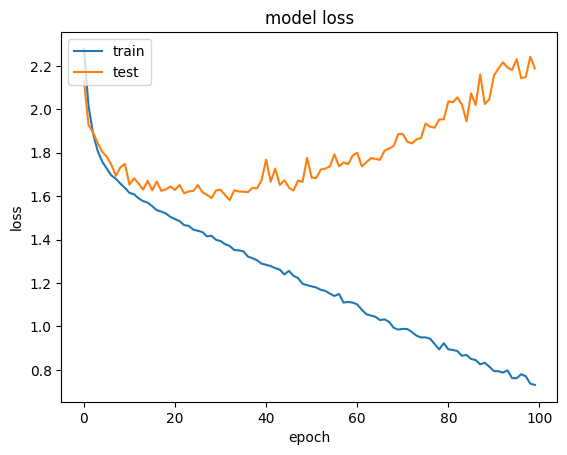

In [82]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

c:\Users\Adril\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Save model and weights at c:\Users\Adril\Desktop\Speech Emotion Detection\saved_models\Emotion_Model.h5 


4. Model Validation


In [84]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.legacy.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
import numpy as np

# Assuming X_test has shape (None, 13, 1)
# Reshape X_test to match the model's input shape
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 216, 1))

# Now evaluate the model using the reshaped input data
score = loaded_model.evaluate(X_test_reshaped, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk


c:\Users\Adril\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\legacy\rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


accuracy: 42.88%


In [85]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

191/191 [==============================] - 4s 21ms/step


array([ 4,  3, 10, ..., 10,  1,  0], dtype=int64)

In [86]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_sad,female_sad
171,female_neutral,female_sad
172,male_angry,male_happy
173,female_disgust,female_disgust
174,male_angry,male_angry
175,female_fear,female_fear
176,male_neutral,male_neutral
177,female_fear,male_neutral
178,female_happy,female_happy
179,female_neutral,female_sad


Lets write the predictions out into a file for re-use

In [87]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,302
female_disgust,323
female_fear,267
female_happy,429
female_neutral,269
female_sad,340
female_surprise,131
male_angry,208
male_disgust,79


In [88]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'


#### Emotion by gender accuracy  

0.42880631371259453


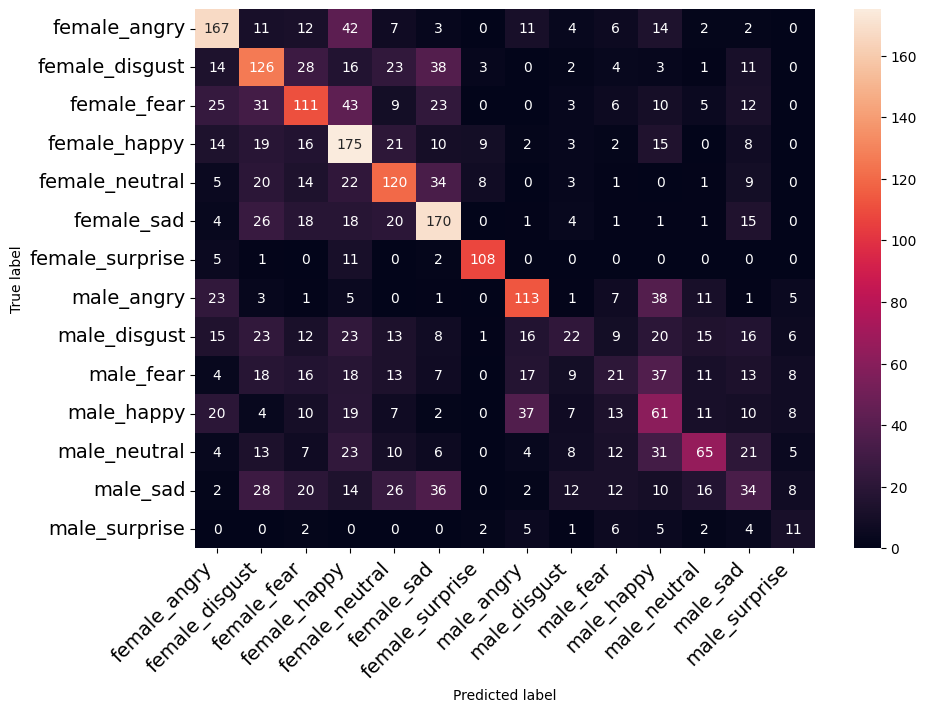

In [89]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [90]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.55      0.59      0.57       281
 female_disgust       0.39      0.47      0.43       269
    female_fear       0.42      0.40      0.41       278
   female_happy       0.41      0.60      0.48       294
 female_neutral       0.45      0.51      0.47       237
     female_sad       0.50      0.61      0.55       279
female_surprise       0.82      0.85      0.84       127
     male_angry       0.54      0.54      0.54       209
   male_disgust       0.28      0.11      0.16       199
      male_fear       0.21      0.11      0.14       192
     male_happy       0.25      0.29      0.27       209
   male_neutral       0.46      0.31      0.37       209
       male_sad       0.22      0.15      0.18       220
  male_surprise       0.22      0.29      0.25        38

       accuracy                           0.43      3041
      macro avg       0.41      0.42      0.40      3041
   weighted avg       0.41   

---------------
#### Gender accuracy result 
if you notice, that the gender classification is more accurate. So lets group them up and measure the accuracy again?

0.7954620190726734


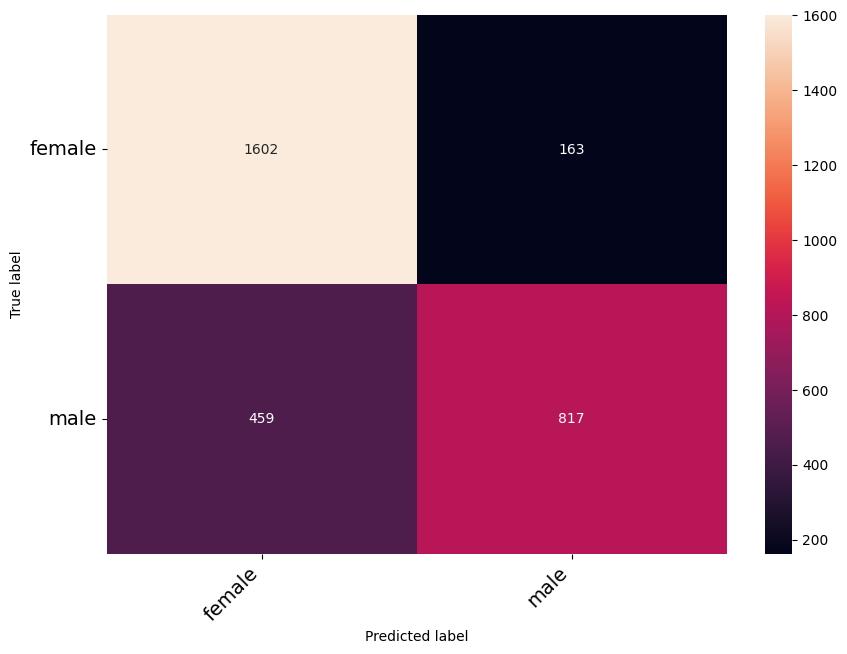

In [91]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [92]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.78      0.91      0.84      1765
        male       0.83      0.64      0.72      1276

    accuracy                           0.80      3041
   macro avg       0.81      0.77      0.78      3041
weighted avg       0.80      0.80      0.79      3041



#### Emotion accuracy
We'll now ignore the gender part and just super group them into the 7 core emotions. Lets see what we get...

0.4876685300887866


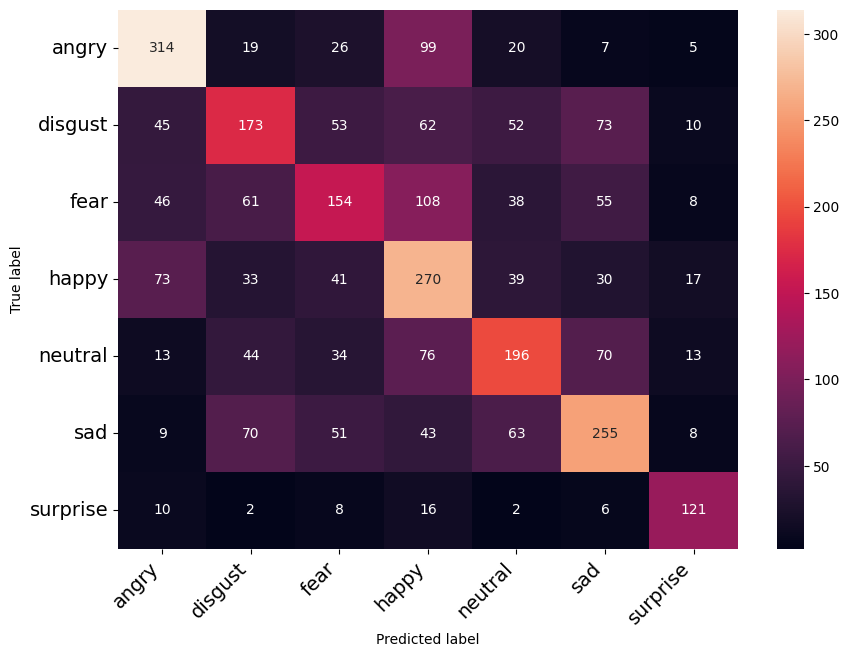

In [93]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [94]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.62      0.64      0.63       490
     disgust       0.43      0.37      0.40       468
        fear       0.42      0.33      0.37       470
       happy       0.40      0.54      0.46       503
     neutral       0.48      0.44      0.46       446
         sad       0.51      0.51      0.51       499
    surprise       0.66      0.73      0.70       165

    accuracy                           0.49      3041
   macro avg       0.50      0.51      0.50      3041
weighted avg       0.49      0.49      0.48      3041

